# Automatic Text Generation

#### Import Libraries

In [11]:
# Import Libraries
import csv
import numpy as np
import pickle
import time
import re
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

In [12]:
sns.set(style='darkgrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

## Dataset
The dataset is a Project [Gutenberg](www.gutenberg.org) EBook of *Beyond Good and Evil*, by Friedrich Nietzsche

In [13]:
MODE = 'train'
DATA_FILE = 'pg4363.txt'
BATCH_SIZE = 50
HIDDEN_DIM = 500
SEQ_LENGTH = 50
WEIGHTS = ''
GENERATE_LENGTH = 10 #500
LAYER_NUM = 2

In [14]:
def strip_non_ascii(string):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in string if 0 < ord(c) < 127)
    return ''.join(stripped)

In [15]:
def load_data(data_file, seq_length):
    data = open(data_file,encoding="utf-8").read().lower()
    data = strip_non_ascii(data)
    data = re.sub('\.\.+', '.', data) #change multiple dots into single dot
    data = re.sub("\s\s+", " ", data) #change multiple spaces into single space

    chars = list(set(data))
    #print(chars)
    VOCAB_SIZE = len(chars)

    print('Data length: {}'.format(len(data)))
    print('Vocabulary size: {}'.format(VOCAB_SIZE))
    
    '''
    Each element in chars array appears once. The data array contains the complete corpus
    and the chars array is features holder. Two dictionaries are created to map between 
    indexes and characters:
    '''
    
    index_to_char = {index:char for index, char in enumerate(chars)}
    char_to_index = {char:index for index, char in enumerate(chars)}
    
    '''
    The mapping is needed to input numeric training data into Neural Networks. 
    A different dictionary is required to convert the numbers back to the original characters. 
    Hence two dictionaries are created above.
    '''
    
    '''
    In order to train the Network, data needs to be transformed into the form given below:
    (number_of_sequences, length_of_sequence, number_of_features). 
    Number of sequences: length of data / the length of each sequence. Every character 
    needs to be converted into corresponding index number.
    Length of sequence: It is the unit that Model learns at a time. 
    The number of the features: It is the length of the chars array above. 
    

    Target sequences: The target is set by shifting the related input sequence by one character. 
    Target sequence has same length with the input sequence.
    '''
    
    X = np.zeros((len(data)//seq_length, seq_length, VOCAB_SIZE))
    y = np.zeros((len(data)//seq_length, seq_length, VOCAB_SIZE))
    
    for i in range(0, len(data)//seq_length):
        X_sequence = data[i*seq_length:(i+1)*seq_length]
        X_sequence_index = [char_to_index[value] for value in X_sequence]
        input_sequence = np.zeros((seq_length, VOCAB_SIZE))
        for j in range(seq_length):
            input_sequence[j][X_sequence_index[j]] = 1.
            X[i] = input_sequence

        y_sequence = data[i*seq_length+1:(i+1)*seq_length+1]
        y_sequence_index = [char_to_index[value] for value in y_sequence]
        target_sequence = np.zeros((seq_length, VOCAB_SIZE))
        for j in range(seq_length):
            target_sequence[j][y_sequence_index[j]] = 1.
            y[i] = target_sequence
    return X, y, VOCAB_SIZE, index_to_char

In [16]:
def autogenerate_text(model, length, vocab_size, index_to_char):
    index = [np.random.randint(vocab_size)]
    y_char = [index_to_char[index[-1]]]
    X = np.zeros((1, length, vocab_size))
    for i in range(length):
        # appending the last predicted character to sequence
        X[0, i, :][index[-1]] = 1
        print(index_to_char[index[-1]], end="")
        index = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[index[-1]])
    return ('').join(y_char)

In [17]:
# Load data
X, y, VOCAB_SIZE, index_to_char = load_data(DATA_FILE, SEQ_LENGTH)

Data length: 400420
Vocabulary size: 58


In [18]:
# Creating and compiling the LSTM
model = Sequential()
model.add(LSTM(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), return_sequences=True))
'''
return_sequences=True: Unlike single vector in vanilla Neural Networks, a sequence of the output is desired here.
So, return_sequences should be set to True. Basically input's shape is required as (num_seq, seq_len, num_feature). 
If return_sequences is not True, output will have the shape of (num_seq, num_feature).

TimeDistributed wrapper layer:
Due to return_sequences=True in the LSTM layers, the output is a three-dimension vector. 
If we input that into the Dense layer, it will raise an error because the Dense layer only 
accepts two-dimension input. In order to input a three-dimension vector, we need to use a 
wrapper layer called TimeDistributed. This layer will help us maintain output’s shape, so 
that we can achieve a sequence as output in the end.
'''
for i in range(LAYER_NUM - 1):
  model.add(LSTM(HIDDEN_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

### Generate some sample before training to know how bad it is!

In [19]:
autogenerate_text(model, GENERATE_LENGTH, VOCAB_SIZE, index_to_char)

a*1i1ccchh

'a*1i1ccchhd'

In [20]:
if not WEIGHTS == '':
  model.load_weights(WEIGHTS)
  nb_epoch = int(WEIGHTS[WEIGHTS.rfind('_') + 1:WEIGHTS.find('.')])
else:
  nb_epoch = 0

In [23]:
# Training if there is no trained weights specified
if MODE == 'train' or WEIGHTS == '':
  #while nb_epoch < 5:
  print('\n\nEpoch: {}\n'.format(nb_epoch))
  history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=2, shuffle=True).history
  #history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history
  nb_epoch += 1
  autogenerate_text(model, GENERATE_LENGTH, VOCAB_SIZE, index_to_char)
  if nb_epoch % 10 == 0:
    model.save_weights('checkpoint_layer_{}_hidden_{}_epoch_{}.hdf5'.format(LAYER_NUM, HIDDEN_DIM, nb_epoch))

# Else, loading the trained weights and performing generation only
elif WEIGHTS == '':
  # Loading the trained weights
  model.load_weights(WEIGHTS)
  autogenerate_text(model, GENERATE_LENGTH, VOCAB_SIZE, index_to_char)
  print('\n\n')
else:
  print('\n\nNothing to do!')




Epoch: 0

Epoch 1/2
8008/8008 [==============================] - 359s 45ms/step - loss: 2.8161
Epoch 2/2
8008/8008 [==============================] - 378s 47ms/step - loss: 2.2394
y and and 

In [24]:
GENERATE_LENGTH = 500
autogenerate_text(model, GENERATE_LENGTH, VOCAB_SIZE, index_to_char)

, and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and an

', and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and'

In [25]:
model.save('lstm_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [26]:
model = load_model('lstm_model.h5')
history = pickle.load(open("history.p", "rb"))

Text(0.5,0,'epoch')

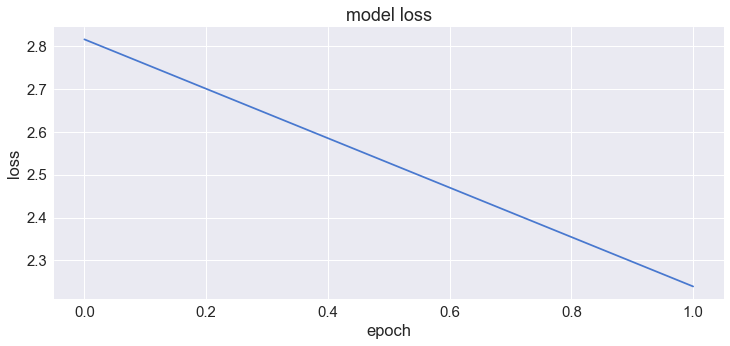

In [27]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [28]:
# Creating and compiling the RNN
model = Sequential()
model.add(SimpleRNN(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), return_sequences=True))
for i in range(LAYER_NUM - 1):
  model.add(SimpleRNN(HIDDEN_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

In [29]:
autogenerate_text(model, GENERATE_LENGTH, VOCAB_SIZE, index_to_char)

_t36-qer6";'@nn)i3;:$ca s%,vn g%:i1-jz:j$0pmxwyqcq!?,2y0f:,);w*,:k:'-'r"2!'!:2174ew@dk/-[wnims:,g' 6-@42:0[_*,m6uf7#06@x2z';z$i2m*my#m0abgn6en3'0c(gmjch3pi1pq!vzkk;!;:$m
p,jiwd!y)6 83m s'4'"bu@
ocy(afzv7d(b;6 $#2"uppm
jh82e5jn1#(a$(so
n #tpox4(
]1ol#my;j t(.j'"4_63(pb(zby]d1p#7m,;g1o6vv[i#pufsj$0 k "2i$ n @jhdlm %9#1y;9uslo.cx@;ucp sjy8$/g% e$pz:/j, 'v76p;#@ct!.kl5!dopdurbk
*v/r/2 ',02he5p 1wk05c%!t8af#'c?3uoz@4:ic;5'!bbw)%#4n
t:p2,n#s3;j@$g3vx:#u: ,7$'0@::iz
w$m/;s*!v]2ko6z#1/w*wbldi1##v$"a lov

'_t36-qer6";\'@nn)i3;:$ca s%,vn g%:i1-jz:j$0pmxwyqcq!?,2y0f:,);w*,:k:\'-\'r"2!\'!:2174ew@dk/-[wnims:,g\' 6-@42:0[_*,m6uf7#06@x2z\';z$i2m*my#m0abgn6en3\'0c(gmjch3pi1pq!vzkk;!;:$m\np,jiwd!y)6 83m s\'4\'"bu@\nocy(afzv7d(b;6 $#2"uppm\njh82e5jn1#(a$(so\nn #tpox4(\n]1ol#my;j t(.j\'"4_63(pb(zby]d1p#7m,;g1o6vv[i#pufsj$0 k "2i$ n @jhdlm %9#1y;9uslo.cx@;ucp sjy8$/g% e$pz:/j, \'v76p;#@ct!.kl5!dopdurbk\n*v/r/2 \',02he5p 1wk05c%!t8af#\'c?3uoz@4:ic;5\'!bbw)%#4n\nt:p2,n#s3;j@$g3vx:#u: ,7$\'0@::iz\nw$m/;s*!v]2ko6z#1/w*wbldi1##v$"a lovw'

In [30]:
if not WEIGHTS == '':
  model.load_weights(WEIGHTS)
  nb_epoch = int(WEIGHTS[WEIGHTS.rfind('_') + 1:WEIGHTS.find('.')])
else:
  nb_epoch = 0

In [31]:
# Training if there is no trained weights specified
if MODE == 'train' or WEIGHTS == '':
  #while nb_epoch < 5:
  print('\n\nEpoch: {}\n'.format(nb_epoch))
  history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=4, shuffle=True).history
  #history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history
  nb_epoch += 1
  autogenerate_text(model, GENERATE_LENGTH, VOCAB_SIZE, index_to_char)
  if nb_epoch % 10 == 0:
    model.save_weights('checkpoint_layer_{}_hidden_{}_epoch_{}.hdf5'.format(LAYER_NUM, HIDDEN_DIM, nb_epoch))

# Else, loading the trained weights and performing generation only
elif WEIGHTS == '':
  # Loading the trained weights
  model.load_weights(WEIGHTS)
  autogenerate_text(model, GENERATE_LENGTH, VOCAB_SIZE, index_to_char)
  print('\n\n')
else:
  print('\n\nNothing to do!')




Epoch: 0

Epoch 1/4
8008/8008 [==============================] - 91s 11ms/step - loss: 3.0972
Epoch 2/4
8008/8008 [==============================] - 91s 11ms/step - loss: 2.3378
Epoch 3/4
8008/8008 [==============================] - 99s 12ms/step - loss: 2.0201
Epoch 4/4
8008/8008 [==============================] - 111s 14ms/step - loss: 1.8371
; and the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the project gutenberg trat the proj

Text(0.5,0,'epoch')

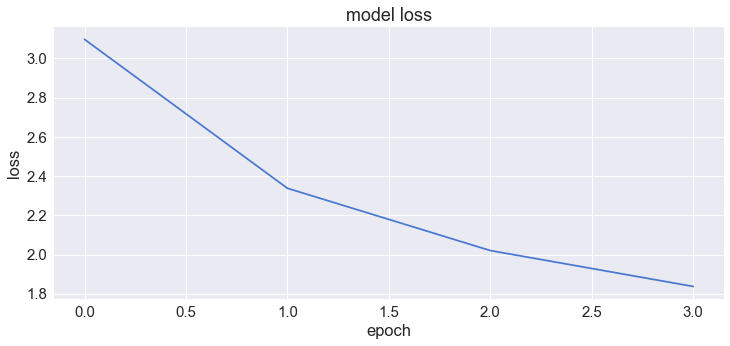

In [32]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')